# Overview
- opencv2を使って遊ぶ

# Const

In [2]:
PATH_01 = './../images/image01.jpg'
PATH_02 = './../images/image02.jpg'

# Import

In [3]:
import numpy as np
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
import cv2

# Function

# Preparation

画像を読み込む(RGB)

In [4]:
img01 = cv2.imread(PATH_01)
img01 = cv2.cvtColor(img01, cv2.COLOR_BGR2RGB)

img02 = cv2.imread(PATH_02)
img02 = cv2.cvtColor(img02, cv2.COLOR_BGR2RGB)

# image01

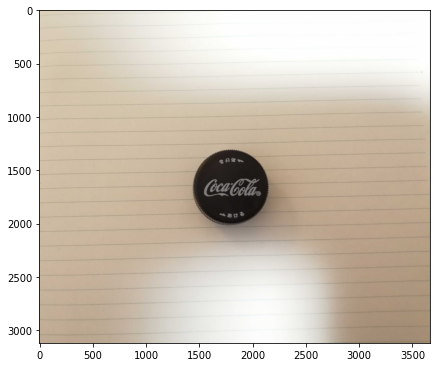

In [5]:
fig = plt.figure(figsize=(7, 7))
fig.patch.set_facecolor('white')
plt.imshow(img01)
plt.show()

## キャップの座標を取得してみる
grey画像に変換

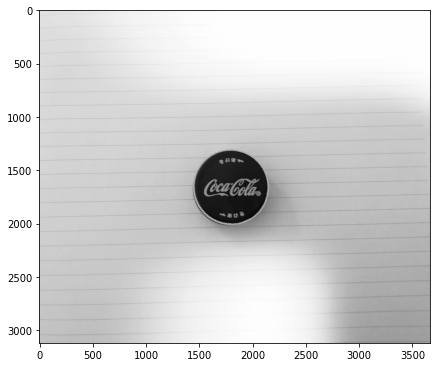

In [116]:
img01_gray = cv2.cvtColor(img01, cv2.COLOR_BGR2GRAY)

img = img01_gray
fig = plt.figure(figsize=(7, 7))
fig.patch.set_facecolor('white')
plt.imshow(img, cmap="Greys_r")
plt.show()

<br>

- 2値化する(黒に近い色を1とする)
- 今回は背景と物体を分ける

Text(0.5, 0, 'intensity')

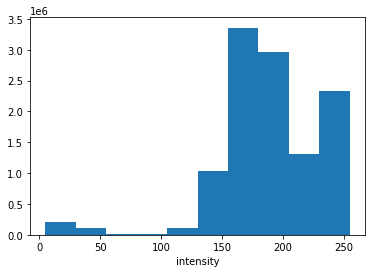

In [117]:
_ = plt.hist(img01_gray.ravel())
plt.xlabel('intensity')

↑閾値を70とかにすれば良さそう

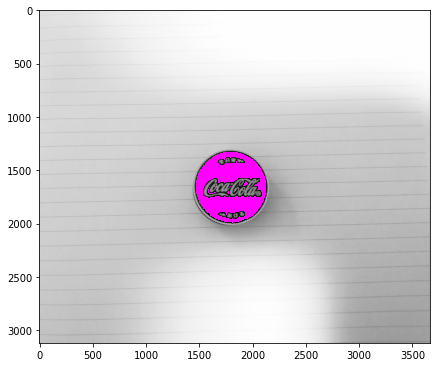

In [118]:
thre = 70
thre, region_gray = cv2.threshold(img01_gray, thre, 1, cv2.THRESH_BINARY_INV)

img = img01_gray
fig = plt.figure(figsize=(7, 7))
fig.patch.set_facecolor('white')
plt.imshow(img, cmap="Greys_r")
plt.imshow(region_gray, cmap="spring_r", alpha=region_gray)
plt.show()

↑ピンクに塗った部分が取得したところ

<br>

穴をうめる

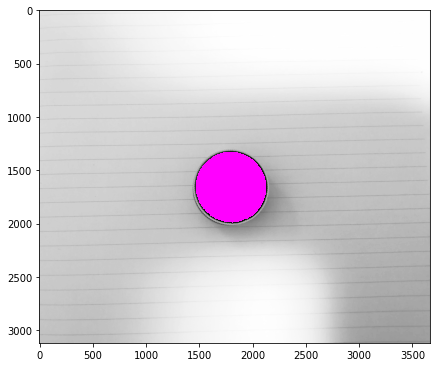

In [119]:
# nlabels, regions = cv2.connectedComponents(img01_gray)
region_fill = ndimage.binary_fill_holes(region_gray).astype(np.uint8)

img = img01_gray
fig = plt.figure(figsize=(7, 7))
fig.patch.set_facecolor('white')
plt.imshow(img, cmap="Greys_r")
plt.imshow(region_fill, cmap="spring_r", alpha=region_fill)
plt.show()

<br>

重心を取得

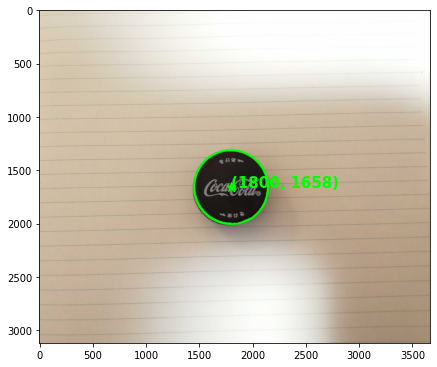

In [121]:
# 輪郭の検出
contours, hierarchy = cv2.findContours(region_fill, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
# 輪郭を１つずつ書き込んで出力
for i in range(len(contours)):
    area = cv2.contourArea(contours[i])
    if area > 10000:
        img01_cont = cv2.drawContours(img01, contours, i, (0, 255, 0), 10)
        plt.figure(figsize=(7, 7))
        plt.imshow(img01_cont)
        
        # 重心を計算
        mu = cv2.moments(contours[i], False)
        x, y= int(mu["m10"]/mu["m00"]) , int(mu["m01"]/mu["m00"])
        plt.scatter(x, y, color='#00ff00', marker='*', s=100)
        plt.text(x, y, f'({x}, {y})', color='#00ff00', size=15, fontweight='bold')

# image02

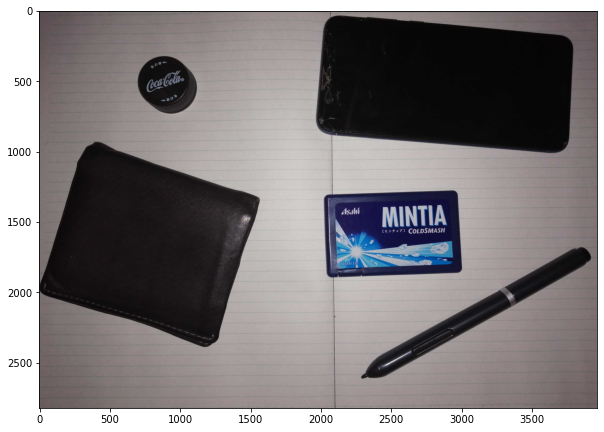

In [265]:
fig = plt.figure(figsize=(10, 10))
fig.patch.set_facecolor('white')
plt.imshow(img02)
plt.show()

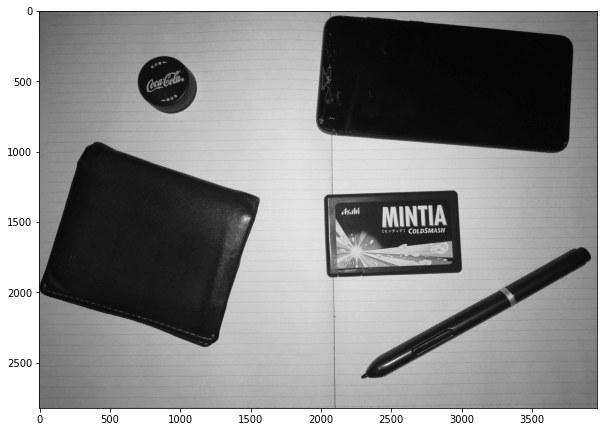

In [110]:
img02_gray = cv2.cvtColor(img02, cv2.COLOR_BGR2GRAY)

img = img02_gray
fig = plt.figure(figsize=(10, 10))
fig.patch.set_facecolor('white')
plt.imshow(img, cmap="Greys_r")
plt.show()

# キャップの座標を取得する
まずは、背景と物体を分ける

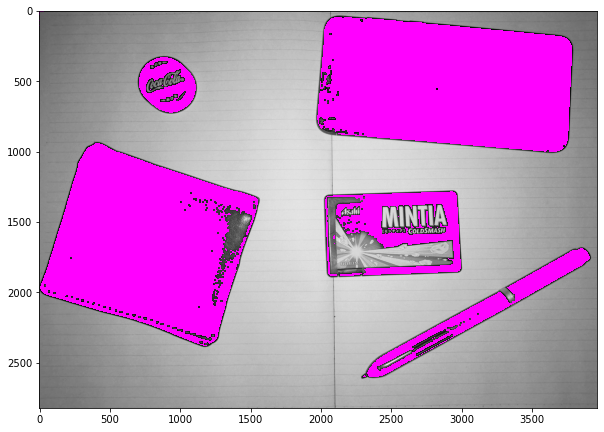

In [111]:
thre = 80
thre, region_gray = cv2.threshold(img02_gray, thre, 1, cv2.THRESH_BINARY_INV)

img = img02_gray
fig = plt.figure(figsize=(10, 10))
fig.patch.set_facecolor('white')
plt.imshow(img, cmap="Greys_r")
plt.imshow(region_gray, cmap="spring_r", alpha=region_gray)
plt.show()

<br>  
モルフォロジー変換(closing, opening)でつなげる

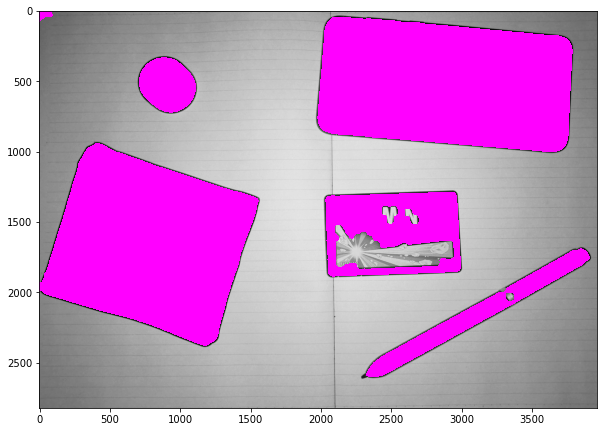

In [113]:
s = 40
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (s, s))
region_gray = cv2.morphologyEx(region_gray, cv2.MORPH_CLOSE, kernel)
region_gray = cv2.morphologyEx(region_gray, cv2.MORPH_OPEN, kernel)

img = img02_gray
fig = plt.figure(figsize=(10, 10))
fig.patch.set_facecolor('white')
plt.imshow(img, cmap="Greys_r")
plt.imshow(region_gray, cmap="spring_r", alpha=region_gray)
plt.show()

<br>

穴埋め

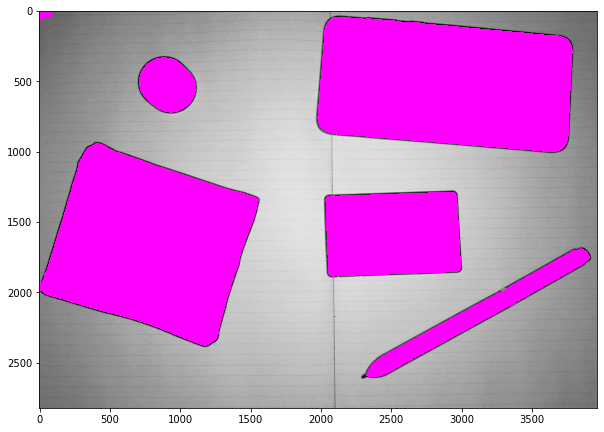

In [114]:
region_gray = ndimage.binary_fill_holes(region_gray).astype(np.uint8)

img = img02_gray
fig = plt.figure(figsize=(10, 10))
fig.patch.set_facecolor('white')
plt.imshow(img, cmap="Greys_r")
plt.imshow(region_gray, cmap="spring_r", alpha=region_gray)
plt.show()

<br>

- 連続している領域を1つのオブジェクトとする(ラベリング)
- 輪郭を抽出
- 面積が小さいものは除去(ノイズ除去)

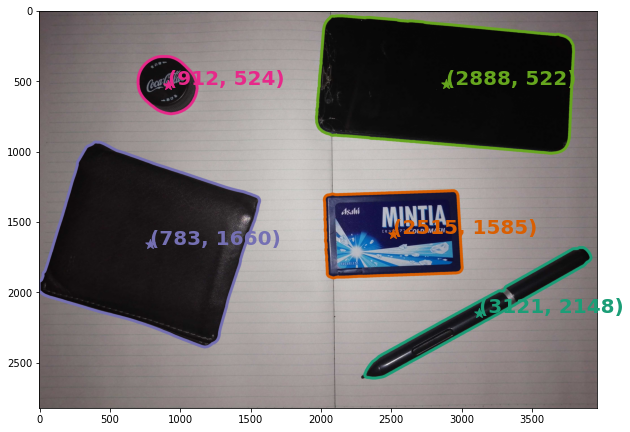

In [309]:
# 輪郭を抽出する。
contours, hierarchy = cv2.findContours(region_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 小さい輪郭は誤検出として削除する
contours = list(filter(lambda x: cv2.contourArea(x) > 10000, contours))

# 重心を求める
centers = []
for cnt in contours:
    mu = cv2.moments(cnt, False)
    x, y= int(mu["m10"]/mu["m00"]) , int(mu["m01"]/mu["m00"])
    centers.append((x, y))

# 輪郭を描画する。
cmap = plt.get_cmap("Dark2")
img02_cont = img02.copy()
for i, cont in enumerate(contours):
    c = (int(cmap(i)[0]*255), int(cmap(i)[1]*255), int(cmap(i)[2]*255))
    img02_cont = cv2.drawContours(img02_cont, contours, i, color=c, thickness=20)

# 描画
plt.figure(figsize=(10, 10))
plt.imshow(img02_cont)
for i, center in enumerate(centers):
    plt.scatter(center[0], center[1], color=cmap(i), marker='*', s=100)
    plt.text(center[0], center[1], f'({center[0]}, {center[1]})', color=cmap(i), size=20, fontweight='bold')

<br>  

キャップの特徴は面積が小さい

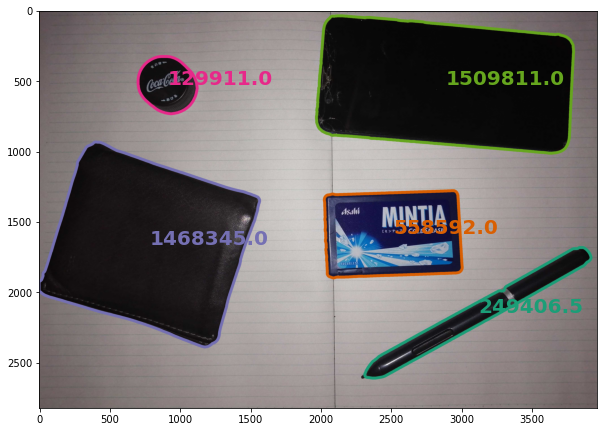

In [310]:
list_area = [cv2.contourArea(cnt) for cnt in contours]
# 輪郭を描画する。
cmap = plt.get_cmap("Dark2")
img02_cont = img02.copy()
for i, cont in enumerate(contours):
    c = (int(cmap(i)[0]*255), int(cmap(i)[1]*255), int(cmap(i)[2]*255))
    img02_cont = cv2.drawContours(img02_cont, contours, i, color=c, thickness=20)
plt.figure(figsize=(10, 10))
plt.imshow(img02_cont)
for i, center in enumerate(centers):
    plt.text(center[0], center[1], f'{list_area[i]}', color=cmap(i), size=20, fontweight='bold')

<br>  

面積最小の輪郭を取得

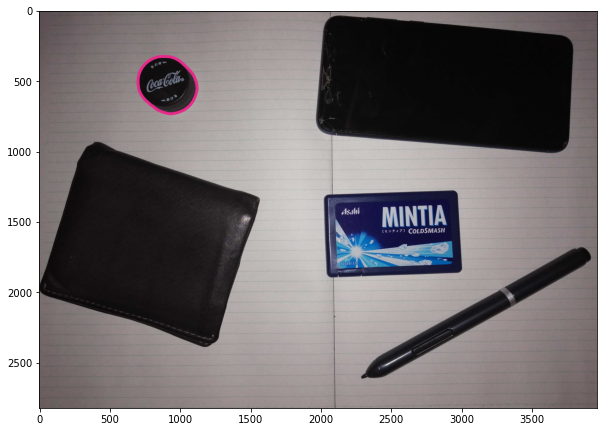

In [314]:
idx_min_area = np.argmin(list_area)

# 輪郭を描画する。
cmap = plt.get_cmap("Dark2")
img02_cont = img02.copy()
for i, cont in enumerate(contours):
    if i == idx_min_area:
        c = (int(cmap(i)[0]*255), int(cmap(i)[1]*255), int(cmap(i)[2]*255))
        img02_cont = cv2.drawContours(img02_cont, contours, i, color=c, thickness=20)
plt.figure(figsize=(10, 10))
plt.imshow(img02_cont)

---> キャップだけ取得できた！

# ペンの座標を取得
- ペンの特徴は細長い
- 特徴量として細長さを取得する
- 細長さは、輪郭の最小外接矩形の width と　height の比で定義することにする

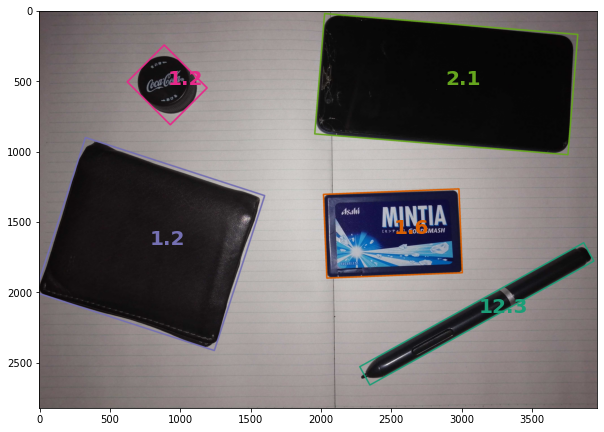

In [331]:
# 輪郭を描画する。
cmap = plt.get_cmap("Dark2")
img02_cont = img02.copy()
list_shape = []
list_rect_val = []
for i, cont in enumerate(contours):
    c = (int(cmap(i)[0]*255), int(cmap(i)[1]*255), int(cmap(i)[2]*255))
#     img02_cont = cv2.drawContours(img02_cont, contours, i, color=c, thickness=20)

    # 最小外接矩形
    rect = cv2.minAreaRect(cont)
    list_shape.append(rect[1])
    list_rect_val.append(max(list_shape[i])/min(list_shape[i]))
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    im = cv2.drawContours(img02_cont, [box], 0, c, 10)

# 描画
plt.figure(figsize=(10, 10))
plt.imshow(img02_cont)
for i, center in enumerate(centers):
    plt.text(center[0], center[1],
             f'{list_rect_val[i]:.1f}',
             color=cmap(i), size=20, fontweight='bold')

---> 最大の細長さを持つ輪郭を取得

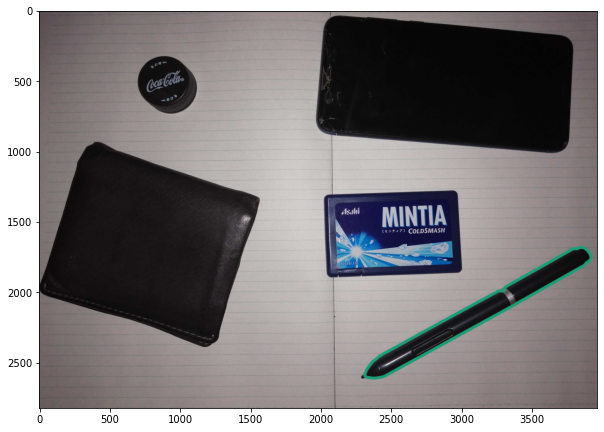

In [335]:
idx = np.argmax(list_rect_val)

# 輪郭を描画する
cmap = plt.get_cmap("Dark2")
img02_cont = img02.copy()
list_shape = []
for i, cont in enumerate(contours):
    if i == idx:
        c = (int(cmap(i)[0]*255), int(cmap(i)[1]*255), int(cmap(i)[2]*255))
        img02_cont = cv2.drawContours(img02_cont, contours, i, color=c, thickness=20)

# 描画
plt.figure(figsize=(10, 10))
plt.imshow(img02_cont)

# MINTIA を取得

- 色が青いのが特徴
- 色空間の変換  
- RGBをHSVにしてH(色相)を使う

https://ja.wikipedia.org/wiki/HSV%E8%89%B2%E7%A9%BA%E9%96%93

In [33]:
img02_hsv = cv2.cvtColor(img02, cv2.COLOR_RGB2HSV)
img02_h = img02_hsv[:, :, 0]

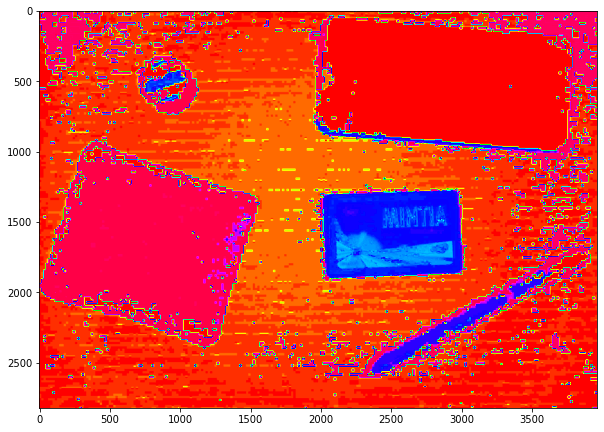

In [124]:
img = img02_h
fig = plt.figure(figsize=(10, 10))
fig.patch.set_facecolor('white')
# plt.imshow(img, cmap="Greys_r")
plt.imshow(img, cmap='hsv')
plt.show()

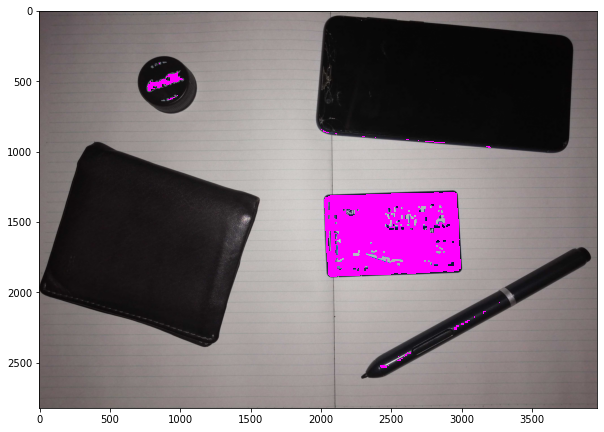

In [125]:
thre, region_h_min = cv2.threshold(img02_h, 90, 1, cv2.THRESH_BINARY_INV)
thre, region_h_max = cv2.threshold(img02_h, 125, 1, cv2.THRESH_BINARY)
region_b = (region_h_min == region_h_max).astype(np.uint8)

img = img02
fig = plt.figure(figsize=(10, 10))
fig.patch.set_facecolor('white')
plt.imshow(img, cmap="Greys_r")
plt.imshow(region_b, cmap="spring_r", alpha=region_b)
plt.show()

<br>  
ノイズを除去しつつ連結する(モルフォロジー変換)

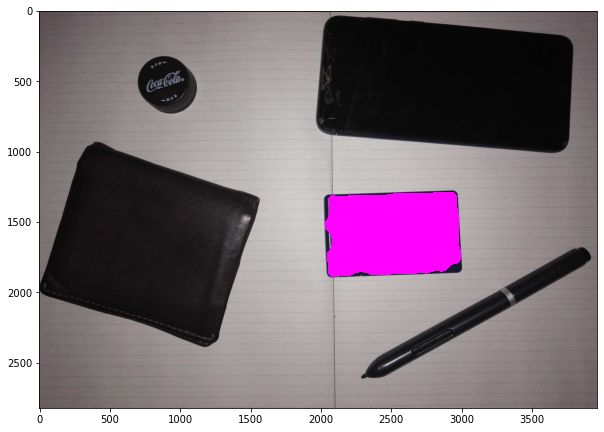

In [126]:
# モルフォロジー変換
s = 70
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (s, s))
region_b_m = cv2.morphologyEx(region_b, cv2.MORPH_OPEN, kernel)
s = 200
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (s, s))
region_b_m = cv2.morphologyEx(region_b_m, cv2.MORPH_CLOSE, kernel)

# 穴埋め
region_b_m = ndimage.binary_fill_holes(region_b_m).astype(np.uint8)

img = img02
fig = plt.figure(figsize=(10, 10))
fig.patch.set_facecolor('white')
plt.imshow(img, cmap="Greys_r")
plt.imshow(region_b_m, cmap="spring_r", alpha=region_b_m)
plt.show()

<br> 
あとは重心を求めるだけ

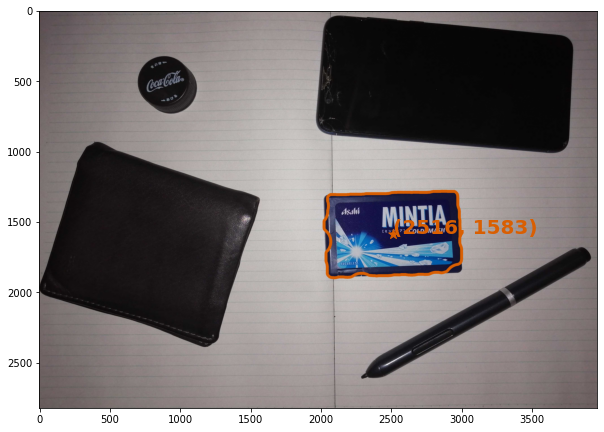

In [107]:
# 輪郭を抽出する。
contours, hierarchy = cv2.findContours(region_b_m, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 小さい輪郭は誤検出として削除する
contours = list(filter(lambda x: cv2.contourArea(x) > 10000, contours))

# 重心を求める
centers = []
for cnt in contours:
    mu = cv2.moments(cnt, False)
    x, y= int(mu["m10"]/mu["m00"]) , int(mu["m01"]/mu["m00"])
    centers.append((x, y))

# 輪郭を描画する。
cmap = plt.get_cmap("Dark2")
img02_cont = img02.copy()
for i, cont in enumerate(contours):
    c = (int(cmap(i+1)[0]*255), int(cmap(i+1)[1]*255), int(cmap(i+1)[2]*255))
    img02_cont = cv2.drawContours(img02_cont, contours, i, color=c, thickness=20)

# 描画
plt.figure(figsize=(10, 10))
plt.imshow(img02_cont)
for i, center in enumerate(centers):
    plt.scatter(center[0], center[1], color=cmap(i+1), marker='*', s=100)
    plt.text(center[0], center[1], f'({center[0]}, {center[1]})', color=cmap(i+1), size=20, fontweight='bold')